# FPCA Clustering

In [1]:
import pandas as pd
import os
import glob
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
from skfda.representation.grid import FDataGrid


import skfda
from skfda.datasets import fetch_growth
from skfda.exploratory.visualization import FPCAPlot
from skfda.preprocessing.dim_reduction import FPCA
from skfda.representation.basis import (
    BSplineBasis,
    FourierBasis,
    MonomialBasis,
)


from __future__ import annotations

from typing import Any, Mapping, Tuple

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import sklearn.cluster
from cartopy.io.img_tiles import GoogleTiles
from matplotlib.axes import Axes
from matplotlib.figure import Figure

from skfda.datasets import fetch_aemet
from skfda.exploratory.depth import ModifiedBandDepth
from skfda.exploratory.visualization import Boxplot, MagnitudeShapePlot
from skfda.exploratory.visualization.fpca import FPCAPlot
from skfda.misc.metrics import l2_distance
from skfda.ml.clustering import KMeans
from skfda.preprocessing.dim_reduction import FPCA

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from kneed import KneeLocator

# Load Data for One Subject, One Frequency

In [2]:
#read each csv file in current_directory and store it in dataframes

current_directory = os.getcwd()
csv_files = glob.glob(os.path.join(current_directory, 'ABR_exported_files/*.csv'))

dataframes = {}
for file in csv_files:
    filename = os.path.splitext(os.path.basename(file))[0]
    if pd.read_csv(file).shape[1] > 1:
        dataframes[filename] = pd.read_csv(file)
    else:
        dataframes[filename] = pd.read_csv(file, skiprows=2)

In [10]:
# SELECT SUBJECT AND FREQUENCY #

######################
subject = 4
frequency = 16000
######################
waves = []
filename = list(dataframes.items())[subject][0]
df = list(dataframes.values())[subject]

for khz_value in [frequency]:
    for dbkhz_value in range(0, 95, 5):
        khz = df[df['Freq(Hz)'] == khz_value]
        dbkhz = khz[khz['Level(dB)'] == dbkhz_value]
        if not dbkhz.empty:
            index = dbkhz.index.values[0]
            final = df.iloc[index,48:]
            final = pd.to_numeric(final, errors='coerce')
            waves.append(final.tolist())
waves = [wave[:-1] for wave in waves]

# PLOT WAVES

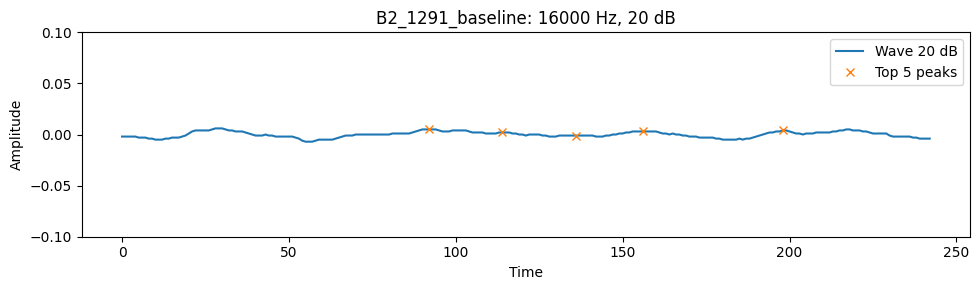

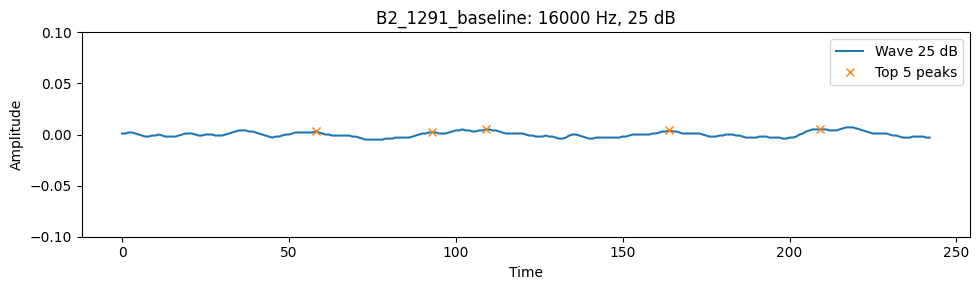

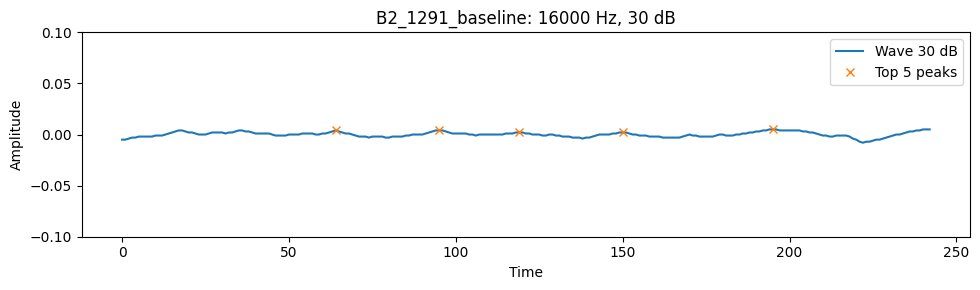

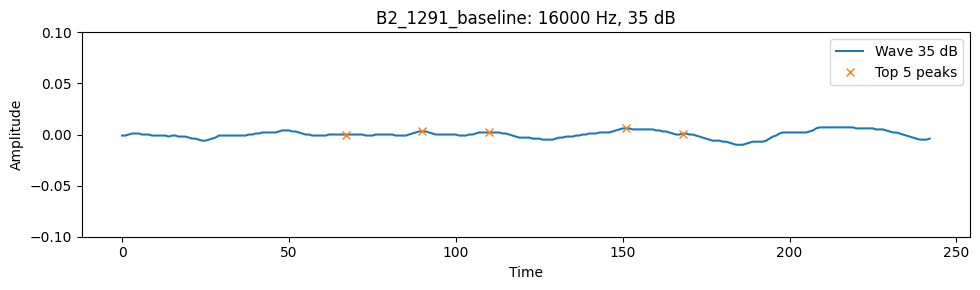

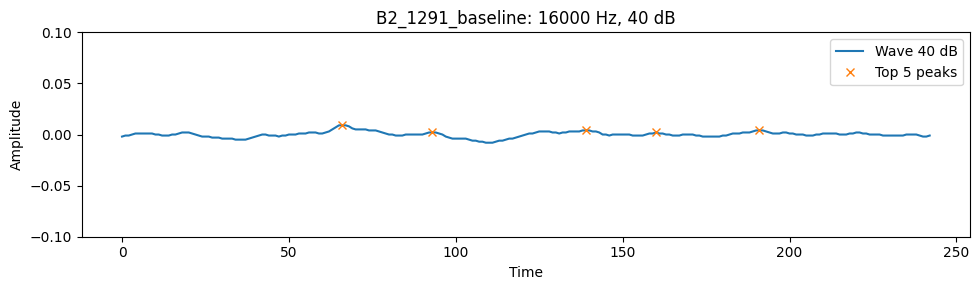

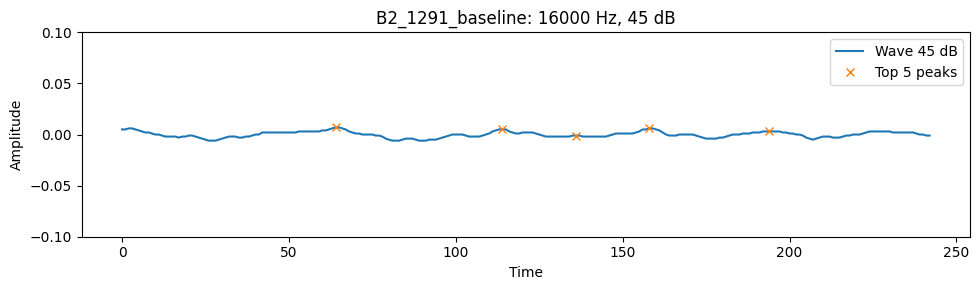

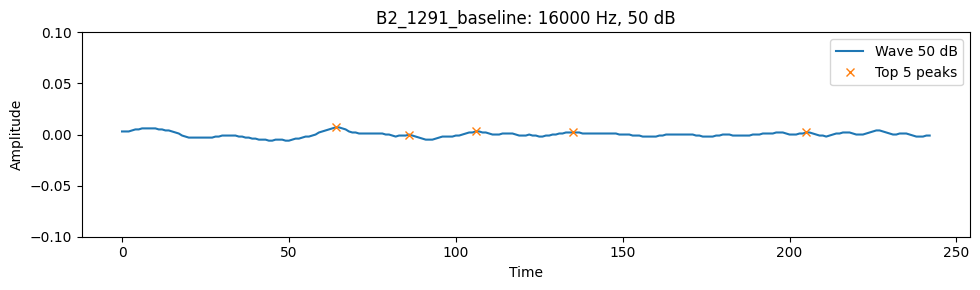

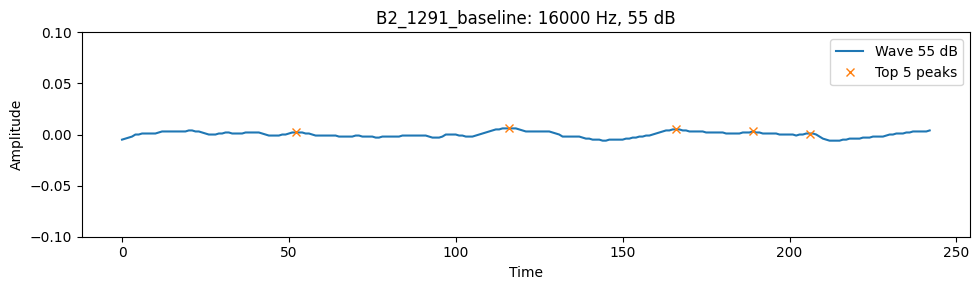

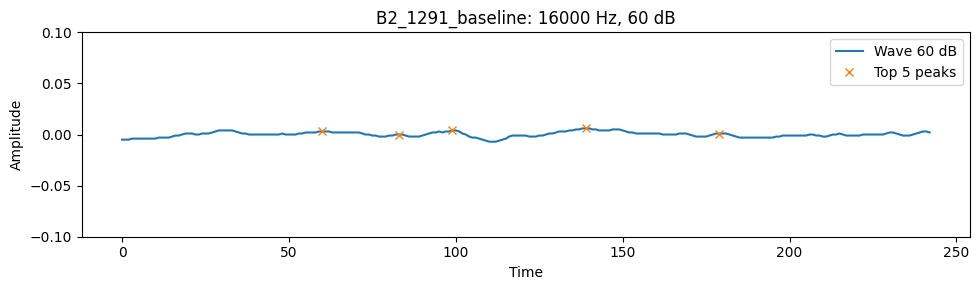

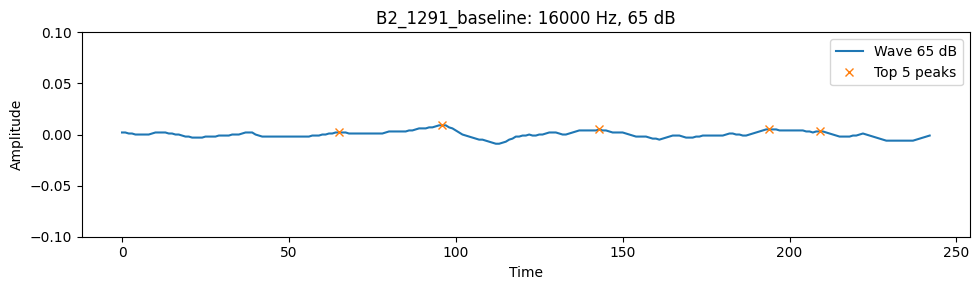

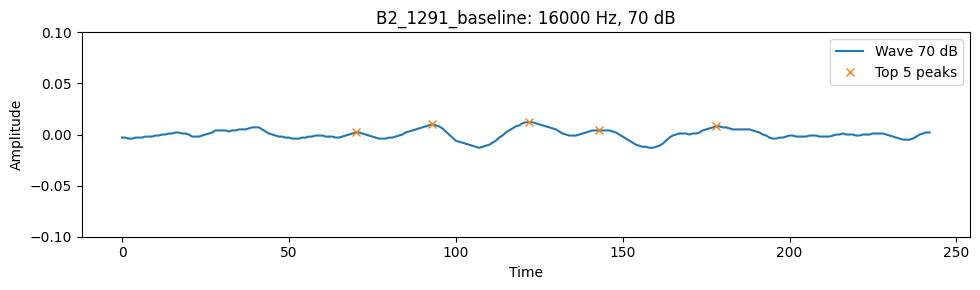

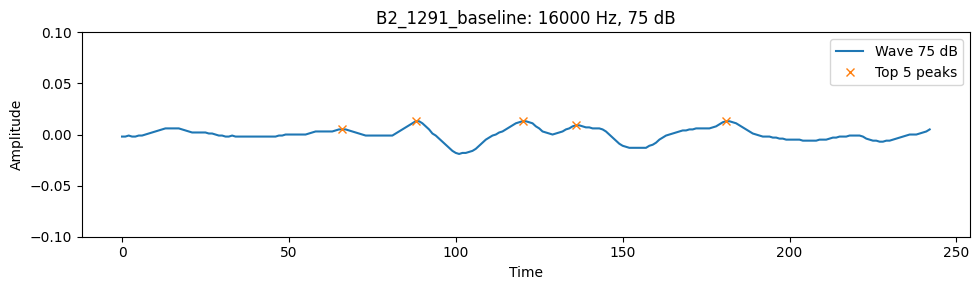

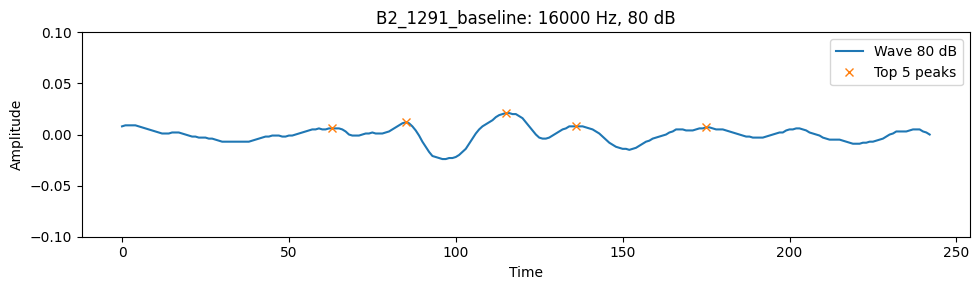

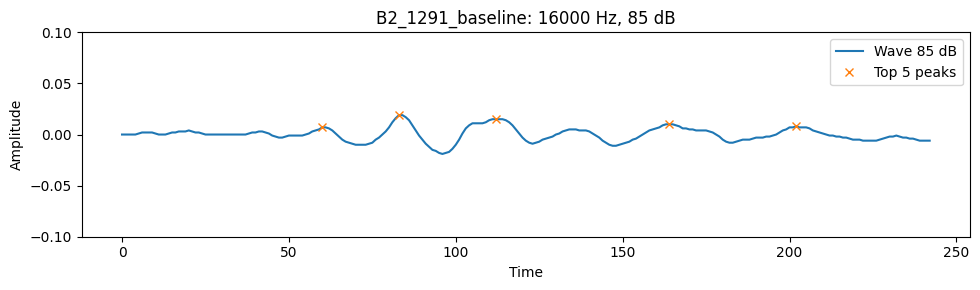

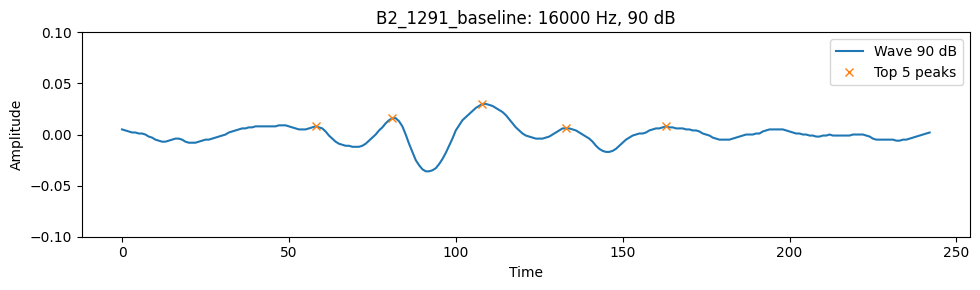

In [11]:
peaks_list = []
db_values = []
freq_values = []

for khz_value in [frequency]:
    for dbkhz_value in range(0, 95, 5):
        khz = df[df['Freq(Hz)'] == khz_value]
        dbkhz = khz[khz['Level(dB)'] == dbkhz_value]
        if not dbkhz.empty:
            index = dbkhz.index.values[0]
            final = df.iloc[index,48:]
            final = pd.to_numeric(final, errors='coerce')
            wave = final.tolist()[:-1]
            wave_after_30 = wave[50:-30]  # start from the 30th point and end before the last 30 points
            peaks, _ = find_peaks(wave_after_30, distance=15)
            peaks = [peak + 50 for peak in peaks]  # adjust the indices
            highest_peaks_indices = sorted(peaks, key=lambda x: wave[x], reverse=True)[:5]
            highest_peaks_indices.sort()
            peak_coordinates = []
            for peak in highest_peaks_indices:
                peak_coordinates.extend([peak, wave[peak]])
            peaks_list.append(peak_coordinates)
            db_values.append(dbkhz_value)
            freq_values.append(khz_value)
            fig, axs = plt.subplots(figsize=(10, 3))
            axs.plot(wave, label=f'Wave {dbkhz_value} dB')
            axs.plot(highest_peaks_indices, [wave[j] for j in highest_peaks_indices], "x", label='Top 5 peaks')
            axs.set_title(f'{filename}: {frequency} Hz, {dbkhz_value} dB')
            axs.set_xlabel('Time')
            axs.set_ylabel('Amplitude')
            axs.set_ylim(-.1,.1)
            axs.legend()
            plt.tight_layout()
            plt.show()

# FPCA on peaks of waves

In [6]:
waves_fd = FDataGrid(waves)
fpca_discretized = FPCA(n_components=3)
fpca_discretized.fit(waves_fd)

FPCA(_weights=array([0.00137174, 0.00548697, 0.00274348, 0.00548697, 0.00274348,
       0.00548697, 0.00274348, 0.00548697, 0.00274348, 0.00548697,
       0.00274348, 0.00548697, 0.00274348, 0.00548697, 0.00274348,
       0.00548697, 0.00274348, 0.00548697, 0.00274348, 0.00548697,
       0.00274348, 0.00548697, 0.00274348, 0.00548697, 0.00274348,
       0.00548697, 0.00274348, 0.00548697, 0.00274348, 0.00548697...
       0.00274348, 0.00548697, 0.00274348, 0.00548697, 0.00274348,
       0.00548697, 0.00274348, 0.00548697, 0.00274348, 0.00548697,
       0.00274348, 0.00548697, 0.00274348, 0.00548697, 0.00274348,
       0.00548697, 0.00274348, 0.00548697, 0.00274348, 0.00548697,
       0.00274348, 0.00548697, 0.00274348, 0.00548697, 0.00274348,
       0.00548697, 0.00274348, 0.00548697, 0.00274348, 0.00548697,
       0.00274348, 0.00514403, 0.00411523, 0.00171468]),
     n_components=3)

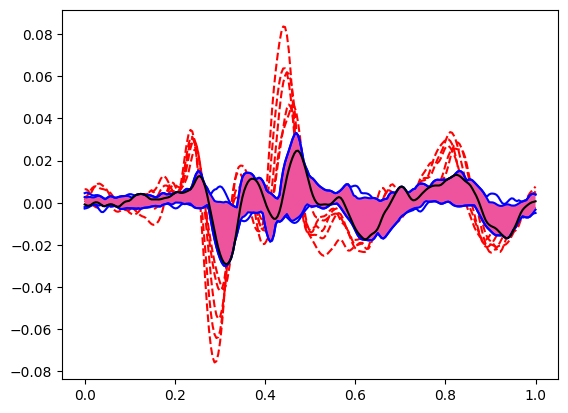

In [7]:
Boxplot(
    waves_fd,
    depth_method=ModifiedBandDepth(),
).plot()
plt.show()

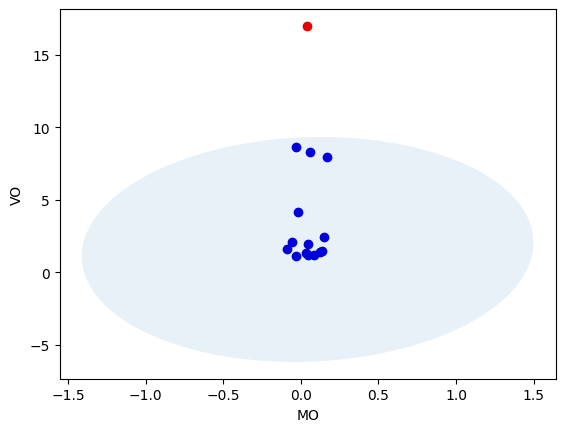

In [8]:
MagnitudeShapePlot(
    waves_fd,
).plot()
plt.show()

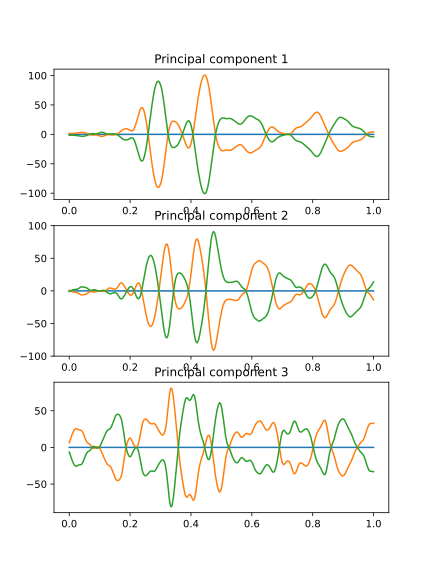

In [9]:
FPCAPlot(
    waves_fd.mean(),
    fpca_discretized.components_,
    factor=30,
    fig=plt.figure(figsize=(6, 2 * 4)),
    n_rows=3,
)

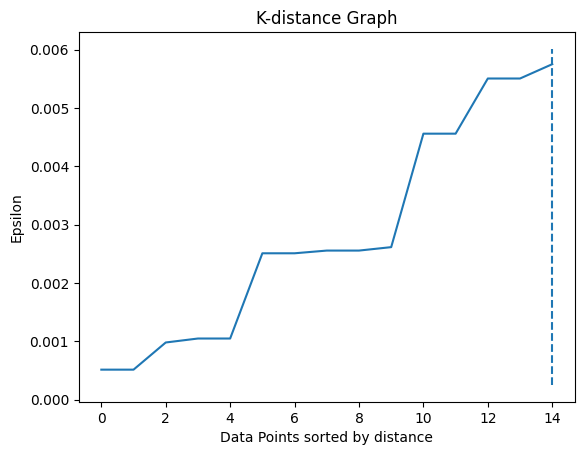

In [10]:
projection = fpca_discretized.transform(waves_fd)

# Get the projections of the first three components
first_component_projection = projection[:, 0]
second_component_projection = projection[:, 1]
third_component_projection = projection[:, 2]

# Determine the optimal eps using K-distance Graph
nearest_neighbors = NearestNeighbors(n_neighbors=2)
neighbors = nearest_neighbors.fit(projection[:, :3])
distances, indices = neighbors.kneighbors(projection[:, :3])
distances = np.sort(distances, axis=0)
distances = distances[:,1]

# Use KneeLocator to find the elbow point
knee_locator = KneeLocator(range(len(distances)), distances, curve='convex', direction='increasing')
eps = distances[knee_locator.knee]

plt.figure()
plt.plot(distances)
plt.title('K-distance Graph')
plt.xlabel('Data Points sorted by distance')
plt.ylabel('Epsilon')
plt.vlines(knee_locator.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.show()

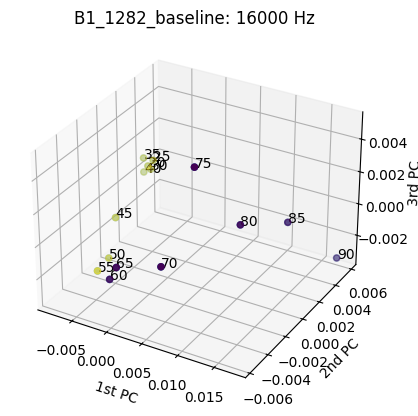

In [11]:
#Scatterplot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(first_component_projection, second_component_projection, third_component_projection)

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=eps)
clusters = dbscan.fit_predict(projection[:, :3])

# Color the points based on the cluster they belong to
ax.scatter(first_component_projection, second_component_projection, third_component_projection, c=clusters)

# Add labels
for i, db_value in enumerate(db_values):
    ax.text(first_component_projection[i], second_component_projection[i], third_component_projection[i], str(db_value))

plt.title(f'{filename}: {frequency} Hz')
ax.set_xlabel('1st PC')
ax.set_ylabel('2nd PC')
ax.set_zlabel('3rd PC')
plt.show()

In [12]:
import pandas as pd

# Create a DataFrame from the projection
df = pd.DataFrame(projection[:, :3], columns=['1st_PC', '2nd_PC', '3rd_PC'])

# Add the cluster assignments to the DataFrame
df['Cluster'] = clusters
# Add the db_values to the DataFrame
df['DB_Value'] = db_values

# Display the DataFrame
print(df)



      1st_PC    2nd_PC    3rd_PC  Cluster  DB_Value
0  -0.006582  0.002810  0.001033        0        20
1  -0.006361  0.003233  0.001224        0        25
2  -0.007057  0.003457  0.000471        0        30
3  -0.007900  0.003299  0.001159        0        35
4  -0.008141  0.003479  0.000155        0        40
5  -0.007270 -0.000247 -0.000866        0        45
6  -0.006206 -0.001784 -0.002538        0        50
7  -0.004789 -0.003926 -0.002054        0        55
8  -0.001591 -0.004926 -0.001630       -1        60
9   0.000438 -0.005636 -0.000251       -1        65
10  0.006307 -0.005352  0.000428       -1        70
11  0.007153 -0.002469  0.005039       -1        75
12  0.011292 -0.000744  0.001285       -1        80
13  0.013347  0.003053 -0.000175       -1        85
14  0.017361  0.005753 -0.003281       -1        90


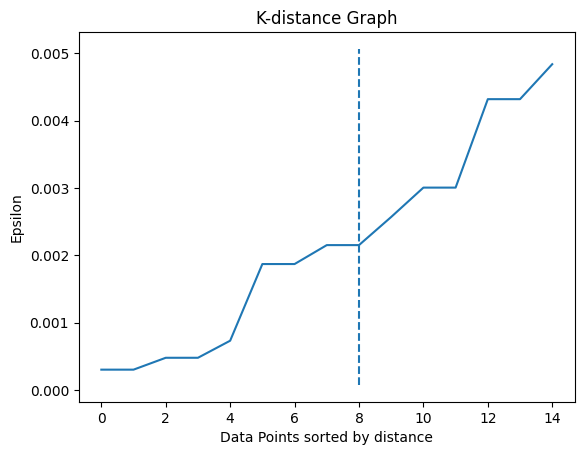

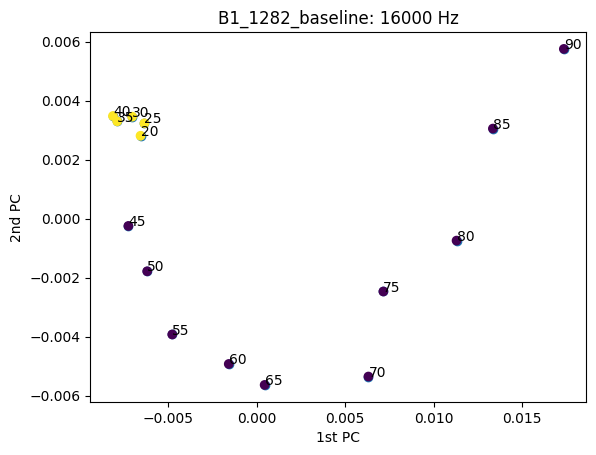

      1st_PC    2nd_PC  Cluster  DB_Value
0  -0.006582  0.002810        0        20
1  -0.006361  0.003233        0        25
2  -0.007057  0.003457        0        30
3  -0.007900  0.003299        0        35
4  -0.008141  0.003479        0        40
5  -0.007270 -0.000247       -1        45
6  -0.006206 -0.001784       -1        50
7  -0.004789 -0.003926       -1        55
8  -0.001591 -0.004926       -1        60
9   0.000438 -0.005636       -1        65
10  0.006307 -0.005352       -1        70
11  0.007153 -0.002469       -1        75
12  0.011292 -0.000744       -1        80
13  0.013347  0.003053       -1        85
14  0.017361  0.005753       -1        90


In [13]:
# Importing necessary libraries
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt
from kneed import KneeLocator
import pandas as pd

# Transforming the data
projection = fpca_discretized.transform(waves_fd)

# Extracting the first two components of the projection
first_component_projection = projection[:, 0]
second_component_projection = projection[:, 1]

# Determining the optimal eps using K-distance Graph
nearest_neighbors = NearestNeighbors(n_neighbors=2)
neighbors = nearest_neighbors.fit(projection[:, :2])
distances, indices = neighbors.kneighbors(projection[:, :2])
distances = np.sort(distances, axis=0)
distances = distances[:,1]

knee_locator = KneeLocator(range(len(distances)), distances, curve='convex', direction='increasing')
eps = distances[knee_locator.knee]

# Plotting the K-distance Graph
plt.figure()
plt.plot(distances)
plt.title('K-distance Graph')
plt.xlabel('Data Points sorted by distance')
plt.ylabel('Epsilon')
plt.vlines(knee_locator.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.show()

# Creating a 2D scatter plot
plt.figure()
plt.scatter(first_component_projection, second_component_projection)

# Applying DBSCAN clustering
dbscan = DBSCAN(eps=eps)
clusters = dbscan.fit_predict(projection[:, :2])

# Coloring the points based on the cluster they belong to
plt.scatter(first_component_projection, second_component_projection, c=clusters)

# Adding labels to the points
for i, db_value in enumerate(db_values):
    plt.text(first_component_projection[i], second_component_projection[i], str(db_value))

# Finalizing the plot
plt.title(f'{filename}: {frequency} Hz')
plt.xlabel('1st PC')
plt.ylabel('2nd PC')
plt.show()

# Creating a DataFrame with each point and its corresponding cluster
df = pd.DataFrame(projection[:, :2], columns=['1st_PC', '2nd_PC'])
df['Cluster'] = clusters
df['DB_Value'] = db_values
print(df)


In [14]:
fpca_discretized.fit(waves_fd)
scores = fpca_discretized.transform(waves_fd)
print(scores)


[[-0.00658212  0.00280954  0.00103275]
 [-0.00636137  0.00323252  0.00122436]
 [-0.00705668  0.00345682  0.00047111]
 [-0.00790048  0.00329929  0.00115879]
 [-0.00814139  0.00347942  0.00015527]
 [-0.00726982 -0.00024721 -0.0008659 ]
 [-0.00620564 -0.0017838  -0.00253839]
 [-0.00478875 -0.00392585 -0.0020542 ]
 [-0.00159128 -0.00492575 -0.00162976]
 [ 0.00043836 -0.00563605 -0.00025061]
 [ 0.00630692 -0.00535182  0.00042813]
 [ 0.00715252 -0.00246909  0.00503903]
 [ 0.01129207 -0.00074418  0.00128517]
 [ 0.01334705  0.00305323 -0.00017482]
 [ 0.01736062  0.00575291 -0.00328091]]


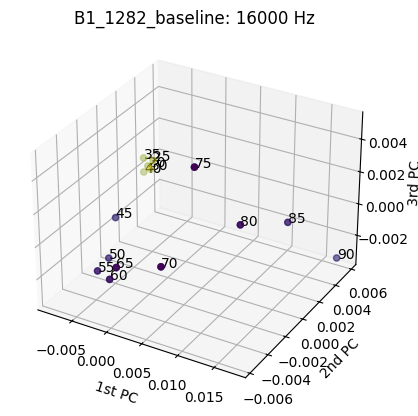

In [15]:
#Scatterplot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(first_component_projection, second_component_projection, third_component_projection)

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=eps)
clusters = dbscan.fit_predict(projection[:, :3])

# Color the points based on the cluster they belong to
ax.scatter(first_component_projection, second_component_projection, third_component_projection, c=clusters)

# Add labels
for i, db_value in enumerate(db_values):
    ax.text(first_component_projection[i], second_component_projection[i], third_component_projection[i], str(db_value))

plt.title(f'{filename}: {frequency} Hz')
ax.set_xlabel('1st PC')
ax.set_ylabel('2nd PC')
ax.set_zlabel('3rd PC')
plt.show()